This is my first article in Kaggle. Thanks for finding, and hope to enjoy.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
!pwd

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Split Test Data

In [ ]:
test_size = 400 #@param {type:"number"}
random_state = 1 #@param {type:"number"}

def prepare_data(*, test_size=0.2, random_state=None):
  data = pd.read_csv('/kaggle/input/text-similarity/train.csv', encoding='utf-8')
  # make origin_index for finding original data
  data.columns.values[0] = 'origin_index'

  train, test = train_test_split(data, test_size=test_size, random_state=random_state)
  return data, train, test

RAW, DATA, TEST = prepare_data(test_size=test_size, random_state=random_state) 
print("RAW:", RAW.shape, '\n', RAW['same_security'].value_counts())
print("DATA:", DATA.shape, '\n', DATA['same_security'].value_counts())
print("TEST:", TEST.shape, '\n', TEST['same_security'].value_counts())

In [ ]:
RAW.tail()

In [ ]:
X, Y = DATA.drop(['same_security'], axis=1), DATA['same_security']
TEST_X, TEST_Y = TEST[['description_x', 'description_y']], TEST['same_security']

# Split Train/Valid Data

In [ ]:
test_size = 0.2 #@param {type:"number"}
random_state =  1#@param {type:"number"}

# Train / Validate Split
TRAIN_X, VALID_X, TRAIN_Y, VALID_Y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

# Summary Data Split

In [ ]:
print("All Data from train.csv (RAW = DATA + TEST) :", RAW.shape)
print()
print("Data for Train and Validate (DATA = [X,Y]) :", DATA.shape)
print("X :", X.shape)
print("Y :", Y.shape)
print()
print("Data for Test (TEST = [TEST_X, TEST_Y]) :", TEST.shape)
print("TEST_X :", TEST_X.shape)
print("TEST_Y :", TEST_Y.shape)
print()
print("TRAIN_X, TRAIN_Y (from X, Y) :", TRAIN_X.shape, TRAIN_Y.shape)
print("VALID_X, VALID_Y (from X, Y) :", VALID_X.shape, VALID_Y.shape)

In [ ]:
TRAIN_X.tail()

In [ ]:
TRAIN_Y.tail()

# EDA for TRAIN Data

In [ ]:
def make_description_ticker_data(data_x):
  df_x = pd.DataFrame({"description":data_x['description_x'].values, "ticker":data_x['ticker_x'].values})
  df_y = pd.DataFrame({"description":data_x['description_y'].values, "ticker":data_x['ticker_y'].values})
  res_df = pd.concat([df_x, df_y], axis=0, ignore_index=True)
  # There are some duplicated descriptions. so, let's drop those. 
  res_df = res_df.drop_duplicates(['description']).reset_index(drop=True)
  return res_df

In [ ]:
DT_DATA = make_description_ticker_data(TRAIN_X)
print(DT_DATA.tail())
print()
print("description/ticker")
print(DT_DATA.describe())
print()
print("description Column")
print(DT_DATA.description.str.len().describe())

# Establish All Combinations of desciptions

In [ ]:
def product_merge(df1, df2, *, verbose=False):
  res_df = pd.DataFrame(columns=df1.columns.to_list()+df2.columns.to_list())
  for i in range(df2.shape[0]):
    combi_df2 = pd.concat([df2.iloc[i:], df2.iloc[:i]], axis=0, ignore_index=True)
    combi_current = pd.concat([df1.reset_index(drop=True),combi_df2.reset_index(drop=True)], axis=1, ignore_index=False)
    res_df = pd.concat([res_df,combi_current], axis=0, ignore_index=True)
    if verbose:
      print (i, "/", df2.shape[0], ": Data Count =", len(res_df))
  return res_df

def regenerate_data(data_x):
  res_df = make_description_ticker_data(data_x)

  raw_x = res_df.rename(columns={'description':'description_x', 'ticker':'ticker_x'})
  raw_y = res_df.rename(columns={'description':'description_y', 'ticker':'ticker_y'})
  x_df = product_merge(raw_x, raw_y, verbose=False)
  x_df = pd.merge(data_x, x_df, how='right')
  x_df = x_df[data_x.columns]

  # Labeling
  y = x_df['ticker_x'] == x_df['ticker_y']

  return x_df, y

In [ ]:
TRAIN_SPACE_X, TRAIN_SPACE_Y = regenerate_data(TRAIN_X)

In [ ]:
print("== TRAIN ==")
print(TRAIN_Y.value_counts())
print("TRAIN_X, TRAIN_Y", TRAIN_X.shape, TRAIN_Y.shape)
print()

print("== TRAIN SPACE ==")
print(TRAIN_SPACE_Y.value_counts())
print("TRAIN_SPACE_X, TRAIN_SPACE_Y", TRAIN_SPACE_X.shape, TRAIN_SPACE_Y.shape)

# Define function for selecting training data

In [ ]:
# Use TRAIN Data as self
def get_sample_origin():
  return TRAIN_X, TRAIN_Y

# Use all combination of descriptions
def get_sample_all():
  return TRAIN_SPACE_X, TRAIN_SPACE_Y

# Random Sampling from all combinations (Considering Class Equality)
def get_sample_random(class_count=7000, random_state=2):
  sample_index = np.concatenate([TRAIN_SPACE_Y[TRAIN_SPACE_Y].sample(n=class_count, random_state=random_state).index, 
                                TRAIN_SPACE_Y[~TRAIN_SPACE_Y].sample(n=class_count, random_state=random_state).index],
                                axis=0)
  return  TRAIN_SPACE_X.loc[sample_index], TRAIN_SPACE_Y.loc[sample_index]

# Random Sampling from False Only (Considering Class Equality)
def get_sample_add(random_state=2):
  origin_target_y = TRAIN_SPACE_Y[TRAIN_SPACE_X.origin_index.notnull()]
  v_count = origin_target_y.value_counts()
  small_label = v_count[True] < v_count[False]
  lack_count = abs(v_count[True] - v_count[False])

  sample_target_y = TRAIN_SPACE_Y[TRAIN_SPACE_X.origin_index.isnull()]
  sample_target_y = sample_target_y[sample_target_y==small_label]

  sample_index = np.concatenate([origin_target_y.index,
                                sample_target_y.sample(n=lack_count, random_state=random_state).index],
                                axis=0)
  return  TRAIN_SPACE_X.loc[sample_index], TRAIN_SPACE_Y.loc[sample_index]

Using Original Data is show good result. So let's use get_sample_origin() 

In [ ]:
train_X, train_Y = get_sample_origin() #@param ["get_sample_origin()", "get_sample_all()", "get_sample_random(7230)", "get_sample_random(3000)", "get_sample_add()"] {type:"raw"}

train_Y.value_counts()

# Train and Test as Conventional Machine Learning (and Simple) Manner

## Select Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# dictionary
def get_Vectorizer(data):
  vect = TfidfVectorizer(analyzer='char', ngram_range=(1,10)) #@param ["CountVectorizer()", "TfidfVectorizer()", "CountVectorizer(analyzer='char', ngram_range=(1,10))", "TfidfVectorizer(analyzer='char', ngram_range=(1,10))"] {type:"raw", allow-input: true}
  vect.fit(np.concatenate([data.description_x, data.description_y], axis=0))
  return vect

## Feature Extraction as simple

In [ ]:
def getFeaturesMap(vect, data):
  from sklearn.metrics import pairwise

  df = pd.DataFrame(index=data.index)

  bow_x = vect.transform(data.description_x)
  bow_y = vect.transform(data.description_y)

  df['__cos'] = pairwise.paired_cosine_distances(bow_x, bow_y)
  df['__euc'] = pairwise.paired_euclidean_distances(bow_x, bow_y)
  df['__man'] = pairwise.paired_manhattan_distances(bow_x, bow_y)

  return df

In [ ]:
from sklearn.preprocessing import MinMaxScaler

vect = get_Vectorizer(train_X)
train_features = getFeaturesMap(vect, train_X)
scaler = MinMaxScaler()
scaler.fit(train_features)

convert_features = lambda x : scaler.transform(getFeaturesMap(vect, x))

## Plot train data

In [ ]:
def plot_3d_feature(dataX, dataY, *, title=None, figure=None, subplot_idx=111, azim=-45, elev=45):
  from mpl_toolkits.mplot3d import Axes3D
  input_features = convert_features(dataX)

  if not figure:
    figure = plt.figure(figsize=(10,10))
  ax = figure.add_subplot(subplot_idx, projection='3d') # Axe3D object
  ax.scatter(input_features[:,0], input_features[:,1], input_features[:,2], c = dataY.astype('int'), s=20, alpha=0.5)
  ax.set_xlabel("__cos")
  ax.set_ylabel("__euc")
  ax.set_zlabel("__man")
  ax.view_init(azim=azim, elev=elev)
  if title:
    ax.set_title(title)

In [ ]:
fig = plt.figure(figsize=(15,12))
plot_3d_feature(train_X, train_Y, title="train", figure=fig, subplot_idx=221)
plot_3d_feature(TRAIN_X, TRAIN_Y, title="TRAIN", figure=fig, subplot_idx=222)
plot_3d_feature(VALID_X, VALID_Y, title="VALID", figure=fig, subplot_idx=223)
plot_3d_feature(TEST_X, TEST_Y, title="TEST", figure=fig, subplot_idx=224)
plt.show()

## Define train and validate process

In [ ]:
from sklearn.metrics import *

def show_result(model, data_X, data_Y, pred_Y):
  print(confusion_matrix(data_Y, pred_Y))
  print(classification_report(data_Y, pred_Y))
  fig = plt.figure(figsize=(15,5))
  plot_3d_feature(data_X, data_Y, title="Truth", figure=fig, subplot_idx=121)
  plot_3d_feature(data_X, pred_Y, title="Prediction", figure=fig, subplot_idx=122)
  plt.show()

def train_and_show(model):
  convert_func = convert_features
  model.fit(convert_func(train_X), train_Y)
  print("== train ==")
  pred_Y = model.predict(convert_func(train_X))
  show_result(model, train_X, train_Y, pred_Y)
  print()
  print("== VALID ==")
  pred_Y = model.predict(convert_func(VALID_X))
  show_result(model, VALID_X, VALID_Y, pred_Y)
  print()
  print("== TEST ==")
  pred_Y = model.predict(convert_func(TEST_X))
  show_result(model, TEST_X, TEST_Y, pred_Y)

#   print()
#   print("== TRAIN ==")
#   pred_Y = model.predict(convert_func(TRAIN_X))
#   show_result(model, TRAIN_X, TRAIN_Y, pred_Y)
  # print()
  # print("== TRAIN_SPACE ==")
  # pred_Y = model.predict(convert_features(TRAIN_SPACE_X))
  # show_result(model, TRAIN_SPACE_X, TRAIN_SPACE_Y)

In [ ]:
compareResult = pd.DataFrame(columns=['Model', 'Accuracy', 'prec_for_False', 'recall_for_False', 'f1_for_False'])

def add_result(name, true_Y, pred_Y):
    acc = accuracy_score(true_Y, pred_Y)
    prec = precision_score(true_Y, pred_Y, pos_label=0)
    recall = recall_score(true_Y, pred_Y, pos_label=0)
    f1 = f1_score(true_Y, pred_Y, pos_label=0)
    compareResult.loc[len(compareResult)] = [name, acc, prec, recall, f1]

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
print(model)
train_and_show(model)
add_result("LR", TEST_Y, model.predict(convert_features(TEST_X)))

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
print(model)
train_and_show(model)
add_result("kNN", TEST_Y, model.predict(convert_features(TEST_X)))

## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
print(model)
train_and_show(model)
add_result("GaussianNB", TEST_Y, model.predict(convert_features(TEST_X)))

## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100,100), learning_rate_init=0.001, max_iter=5000)
print(model)
train_and_show(model)
add_result("MLP", TEST_Y, model.predict(convert_features(TEST_X)))

## Result Overview of Conventional Machine Learning Methods

In [ ]:
compareResult

F1 Scores of 'False' are bad. Accuracy is just to original distribution of class. Therefore, approaches using conventional ML seems to be not optimal way.

# Train and Test as Deep Learning Manner

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

#### Inspired ```Siamese Network```

https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.**pdf**

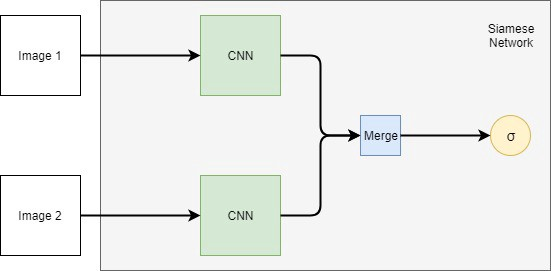



#### overall structure

1. Embedding after encoding by character unit
   -Since the maximum length of description is 79, the input array is 100
2. Design Encoder to change sentence to Vector into DL
3. After changing the Encoder DL with the same structure to Vector, find the likelyhood of True through DenseNet

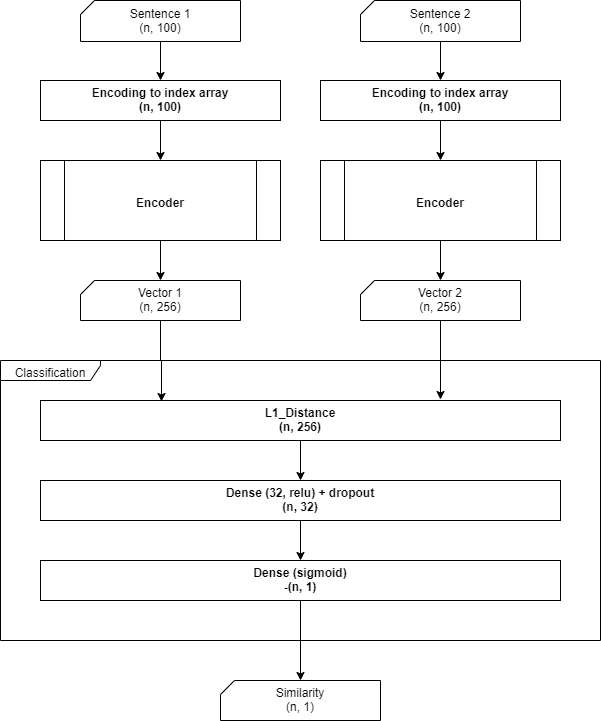

#### Encoder

(Refer to https://github.com/fuzzythecat/awesome-spacer)

1. Encoding and Embedding character by character
2. Use 4,6,8,10 Conv1D to extract meaning between words
3. Use Bidirectional LSTM to understand context meaning
4. Reduce dimensions with TimeDistributed (Dense) to preserve the information of all time steps as much as possible
5. Final Vector Output

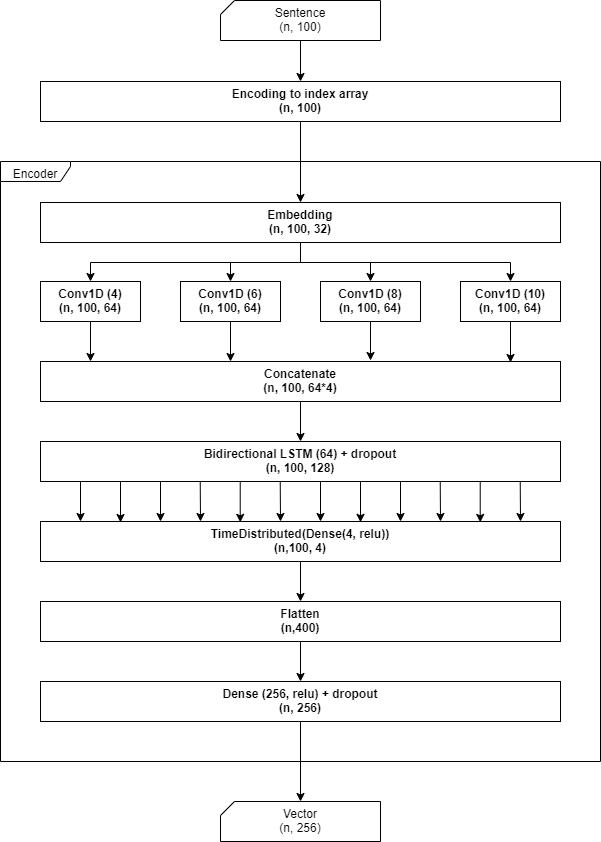

## Implementation

#### CharEncoder

In [ ]:
class CharEncoder(object):

  def __init__(self, *, max_length=100, padding='end'):
    self.CHARS_TOKENS = ['<PAD>', '<START>','<END>', '<UNK>']
    self.CHARS_ALPHA_UPPER = [chr(x) for x in range(0x0041, 0x005b)] #"ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    self.CHARS_ALPHA_LOWER = [chr(x) for x in range(0x0061, 0x007b)] #"abcdefghijklmnopqrstuvwxyz"
    self.CHARS_NUMBERS = [x for x in '0123456789']
    self.CHARS_PUNCTUATIONS  = [x for x in '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~']
    self.CHARS_WHITESPACES = [x for x in '\t\n ']
    self.CHARS = ( self.CHARS_TOKENS 
                + self.CHARS_ALPHA_UPPER
                + self.CHARS_ALPHA_LOWER
                + self.CHARS_NUMBERS
                + self.CHARS_PUNCTUATIONS
                + self.CHARS_WHITESPACES )
    self.INDEXES = {c:i for i,c in enumerate(self.CHARS)}
    self.MAX_LENGTH = max_length
    self.PADDING = padding
    self.LEN = len(self.CHARS)
  

  def text_to_idx(self, s, *, max_length=None, padding=None):
    idx_array = [self.INDEXES['<START>']]
    idx_array += [self.INDEXES[c] if c in self.CHARS else self.INDEXES['<UNK>']
                  for c in s]
    idx_array += [self.INDEXES['<END>']]

    if not max_length:
      max_length = self.MAX_LENGTH

    if not padding:
      padding = self.PADDING

    pad_size = max_length - len(idx_array)
    if 0 < pad_size and padding == 'start':
      idx_array = [self.INDEXES['<PAD>'] for _ in range(pad_size)] + idx_array
    elif 0 < pad_size and padding=='end':
      idx_array = idx_array + [self.INDEXES['<PAD>'] for _ in range(pad_size)]

    return list(idx_array[:max_length])

  def idx_to_text(self, idxes, *, with_token=False):
    char_list = [self.CHARS[i] for i in idxes if i < len(self.CHARS)]
    if with_token != True:
      char_list = [c for c in char_list if c not in self.CHARS_TOKENS]
    return ''.join(char_list)

  def to_idx(self, s_list, *, max_length=None, padding=None):
    return [self.text_to_idx(s, max_length=max_length, padding=padding) 
              for s in s_list]
    
  def to_text(self, idxes_list, *, with_token=False):
    return [self.idx_to_text(idxes, with_token=with_token)
              for idxes in idxes_list]

In [ ]:
enc = CharEncoder(max_length=10, padding='end')

test = ['abcd', 'efg', 'ssss']
test2 = np.array(enc.to_idx(test))
test3 = np.array(enc.to_text(test2))
test4 = np.array(enc.to_text(test2, with_token=True))

print(test)
print(test2)
print(test3)
print(test4)

In [ ]:
enc = CharEncoder(max_length=100, padding='end')
test = np.array(enc.to_idx(train_X.description_x))
print(test.shape)
print(train_X.description_x[:3])
print(test[:3])
print(enc.to_text(test)[:3])


#### Configuration

In [ ]:
class Config(object):

  PADDING = "end"
  
  MAX_TEXT_LEN = 100
  VECTOR_SIZE = 256

  EMBEDDING_DIM = 32

  CONV_FILTER_NUMS = [64, 64, 64, 64] 
  CONV_FILTER_SIZES = [4, 6, 8, 10]

  LSTM_HIDDEN_NUM = 64
  LSTM_DROPOUT = 0.3

  ENC_DENSE_DROPOUT = 0.3
  ENC_DENSE_NUM = VECTOR_SIZE

  LAST_DENSE_DROPOUT = 0.3
  LAST_DENSE_NUM = 32

  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  EPOCHS = 100

  def __init__(self):
    self.ENCODER = CharEncoder(max_length=self.MAX_TEXT_LEN, padding=self.PADDING)
    self.NUM_WORDS = self.ENCODER.LEN

#### Network Model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend

def _obtain_input_shape(max_text_len):
    if not (isinstance(max_text_len, int)):
        raise(ValueError('`max_text_len` should be' +
                         'a single integer.'))
    input_shape = (max_text_len, )
        
    return input_shape

def _conv_block(inputs,
                filter_nums,
                filter_sizes):
    if not all(isinstance(x, int) for x in filter_nums):
        raise(ValueError('`filter_nums` should be a list ' +
                         'of integers.'))
    if not all(isinstance(x, int) for x in filter_sizes):
        raise(ValueError('`filter_sizes` should be a list ' +
                         'of integers.'))
    if not len(filter_nums) == len(filter_sizes):
        raise(ValueError('`filter_nums` and `filter_sizes` should ' +
                         'have the same size.'))

    conv_blocks = []    
    for fn, fs in zip(filter_nums, filter_sizes):
        conv = layers.Conv1D(filters=fn,
                             kernel_size=fs,
                             padding='same',
                             activation='relu',
                             strides=1)(inputs)

        conv_blocks.append(conv)

    return conv_blocks

#@title Encoder Model

def VectEncoder(weights=None, config=None): 
    input_shape = _obtain_input_shape(config.MAX_TEXT_LEN)
    inputs = layers.Input(shape=input_shape)

    x = layers.Embedding(config.NUM_WORDS, 
                         config.EMBEDDING_DIM,
                         input_length=config.MAX_TEXT_LEN)(inputs)
    conv_blocks = _conv_block(x, config.CONV_FILTER_NUMS,
                                 config.CONV_FILTER_SIZES)
    x = layers.Concatenate()(conv_blocks)
    x = layers.Bidirectional(layers.LSTM(config.LSTM_HIDDEN_NUM, dropout=config.LSTM_DROPOUT, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(4, activation='relu'))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(config.ENC_DENSE_DROPOUT)(x)
    x = layers.Dense(config.ENC_DENSE_NUM, activation='relu')(x)

    model = models.Model(inputs, x)

    if weights is not None:
        model.load_weights(weights)
 
    return model

def VectSimilarityEstimator(weights=None, config=None):
  input_shape = _obtain_input_shape(config.VECTOR_SIZE)
  inputs1 = layers.Input(shape=input_shape)
  inputs2 = layers.Input(shape=input_shape)

  x = layers.Lambda(lambda tensors:backend.abs(tensors[0] - tensors[1]))([inputs1, inputs2])
  x = layers.Dropout(config.LAST_DENSE_DROPOUT)(x)
  x = layers.Dense(config.LAST_DENSE_NUM, activation='relu')(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = models.Model([inputs1, inputs2], x)

  if weights is not None:
        model.load_weights(weights)
 
  return model

def SentenceSimilarityEstimator(weights=None, config=None):
  input_shape = _obtain_input_shape(config.MAX_TEXT_LEN)
  sent1 = layers.Input(shape=input_shape)
  sent2 = layers.Input(shape=input_shape)

  encoder_1 = VectEncoder(config=config)
  encoder_2 = VectEncoder(config=config)
  estimator = VectSimilarityEstimator(config=config)

  vect1 = encoder_1(sent1)
  vect2 = encoder_2(sent2)
  similarity = estimator([vect1, vect2])

  model = models.Model([sent1, sent2], similarity)

  if weights is not None:
        model.load_weights(weights)

  return model, encoder_1, encoder_2, estimator

#### Working Model

In [ ]:
import pickle
import gzip

class MyDLModel(object):
  def __init__(self, *, config=None, load_file_prefix=None):
    if load_file_prefix:
      cf,wf = self.__get_file(load_file_prefix)
      self.config = self.__load_config(cf)
      weight_file = wf
    else:
      self.config = config if config else Config()
      weight_file = None
    
    model, encoder_1, encoder_2, estimator = SentenceSimilarityEstimator(config=self.config, weights=weight_file)
    self.model = model
    self.encoder_1 = encoder_1
    self.encoder_2 = encoder_2
    self.estimator = estimator

    self.model.compile(optimizer=keras.optimizers.Adam(self.config.LEARNING_RATE),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
  
  def __get_file(self, prefix):
    config_name = prefix+"_config.pkl"
    weight_name = prefix+"_weight.hd5"
    return config_name, weight_name

  def __load_config(self, load_file):
    with gzip.open(load_file, 'rb') as f:
      config = pickle.load(f)
    return config

  def __save_config(self, save_file):
    with gzip.open(save_file, 'wb') as f:
      config = pickle.dump(self.config, f)
    return config

  def save_model(self, file_name_prefix):
    cf,wf = self.__get_file(file_name_prefix)
    self.model.save_weights(wf)
    self.__save_config(cf)
    print(file_name_prefix,"Saved")

  def summary(self, recusive=False):
    self.model.summary()
    if recusive:
      print()
      print("== encoder_1 ==")
      self.encoder_1.summary()
      print()
      print("== encoder_2 ==")
      self.encoder_2.summary()
      print()
      print("== estimator ==")
      self.estimator.summary()

  def encodeSents(self, data_X):
    enc = self.config.ENCODER
    sents1 = np.array(enc.to_idx(data_X.description_x))
    sents2 = np.array(enc.to_idx(data_X.description_y))
    return [sents1, sents2]

  def makeInt(self, data_Y):
    y = np.array(data_Y.astype('int'))
    return y

  def fit(self, train_X, train_Y, *, valid=None, epochs=None, batch_size=None):
    if valid:
      validation_data = (self.encodeSents(valid[0]), self.makeInt(valid[1]))
    else:
      validation_data = None

    if not epochs:
      epochs = self.config.EPOCHS
    if not batch_size:
      batch_size = self.config.BATCH_SIZE

    history = self.model.fit(self.encodeSents(train_X), self.makeInt(train_Y),
                   epochs=epochs, batch_size=batch_size,
                   validation_data=validation_data)
    
    return history

  def evaluate(self, data_X, data_Y):
    self.model.evaluate(self.encodeSents(data_X), self.makeInt(data_Y))

  def predict_proba(self, data_X):
    y = self.model(self.encodeSents(data_X))
    y = np.array(y).reshape(-1,)
    return y
    
  def predict(self, data_X):
    return 0.5 < self.predict_proba(data_X)

### Train

In [ ]:
model = MyDLModel()
model.summary(True)

In [ ]:
model.evaluate(train_X, train_Y)

In [ ]:
def show_learning_curve(hist):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist.history['loss'], 'y', label='train loss')
  loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='lower left')

  acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
  acc_ax.set_ylabel('accuracy')
  acc_ax.legend(loc='upper left')

  plt.show()

learn_hists = []
def train_and_show_for_DL(model):
  hist = model.fit(train_X, train_Y, valid=(VALID_X, VALID_Y), epochs=100)
  learn_hists.append(hist)
  print("== learning curve ==")
  show_learning_curve(hist)
  print("== train ==")
  pred_Y = model.predict(train_X)
  show_result(model, train_X, train_Y, pred_Y)
  print()
  print("== VALID ==")
  pred_Y = model.predict(VALID_X)
  show_result(model, VALID_X, VALID_Y, pred_Y)
  print()
  print("== TEST ==")
  pred_Y = model.predict(TEST_X)
  show_result(model, TEST_X, TEST_Y, pred_Y)
#   print()
#   print("== TRAIN ==")
#   pred_Y = model.predict(TRAIN_X)
#   show_result(model, TRAIN_X, TRAIN_Y, pred_Y)
  # print()
  # print("== TRAIN_SPACE ==")
  # pred_Y = model.predict(TRAIN_SPACE_X)
  # show_result(model, TRAIN_SPACE_X, TRAIN_SPACE_Y)

In [ ]:
model = MyDLModel()
train_and_show_for_DL(model)
add_result("MyDLModel(100)", TEST_Y, model.predict(TEST_X))

In [ ]:
train_and_show_for_DL(model)
add_result("MyDLModel(200)", TEST_Y, model.predict(TEST_X))

In [ ]:
train_and_show_for_DL(model)
add_result("MyDLModel(300)", TEST_Y, model.predict(TEST_X))

In [ ]:
train_and_show_for_DL(model)
add_result("MyDLModel(400)", TEST_Y, model.predict(TEST_X))

In [ ]:
train_and_show_for_DL(model)
add_result("MyDLModel(500)", TEST_Y, model.predict(TEST_X))

# Comparison

In [ ]:
compareResult

Deep Learning Approach is doing better than ML in this data.

In [ ]:
def getVector1(model, descriptions):
  return  np.array(model.encoder_1(np.array(model.config.ENCODER.to_idx(descriptions))))

def getVector2(model, descriptions):
  return np.array(model.encoder_2(np.array(model.config.ENCODER.to_idx(descriptions))))

def getVectors(model, dataX):
  vector_x = getVector1(model, dataX.description_x)
  vector_y = getVector2(model, dataX.description_y)
  vector_arr = np.array([vector_x, vector_y])
  return np.swapaxes(vector_arr,0,1)

In [ ]:
from sklearn.manifold import TSNE

model_tsne = TSNE(learning_rate=100, random_state=1)

vectors1 =getVector1(model, DT_DATA.description)
vectors2 =getVector2(model, DT_DATA.description)
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1,2)).fit_transform(DT_DATA.description)
print(DT_DATA.description.shape, vectors1.shape, vectors2.shape, tfidf.shape)

tfidf_tsne = model_tsne.fit_transform(tfidf.toarray())
vectors1_tsne = model_tsne.fit_transform(vectors1)
vectors2_tsne = model_tsne.fit_transform(vectors2)


In [ ]:
fig = plt.figure(figsize=(25,7))

ax = fig.add_subplot(131)
ax.scatter(tfidf_tsne[:,0],tfidf_tsne[:,1])
ax.set_title("TFIDF")

ax = fig.add_subplot(132)
ax.scatter(vectors1_tsne[:,0],vectors1_tsne[:,1])
ax.set_title("VECTOR_1")

ax = fig.add_subplot(133)
ax.scatter(vectors2_tsne[:,0],vectors2_tsne[:,1])
ax.set_title("VECTOR_2")
plt.show()

Both shape of Vector_1 and Vetctor2 are showing like kind of symmetric. It means that the two encoders are doing same manners.

Thank you for reading.